In [1]:
import numpy as np 
import os
from astropy.io import fits
import healpy as hp
from scipy.interpolate import RegularGridInterpolator, griddata
from healpy.projector import GnomonicProj
import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
import matplotlib.image as mpig
from gwcs.wcstools import wcs_from_points
from astropy.modeling.projections import Sky2Pix_ZEA
import asdf 
import matplotlib.pyplot as plt

In [2]:
def cart2pol(x,y):
    theta = np.arctan2(y,x)
    rho = np.hypot(x,y)
    return theta, rho

def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x,y

def get_healpix_data(h_nside, lim_deg):
    img_npix = hp.nside2npix(h_nside)
    h_img = np.arange(img_npix)
    h_theta, h_phi = hp.pix2ang(h_nside, h_img, nest=True)
    up_id = h_theta < np.deg2rad(lim_deg)
    do_id = h_theta >= np.deg2rad(lim_deg)
    h_img[do_id] = -1
    return h_theta, h_phi, h_img, up_id

In [3]:
def get_img_tab(ipath, sex_path, dimg, cen, img_nside, proj_dx, proj_dy):
    # image size
    img_nx = np.arange(cen[2]*2)
    img_ny = np.arange(cen[2]*2)

    # healpix map
    heal_theta, heal_phi, heal_img, up_id = get_healpix_data(img_nside, 90.)
    heal_r = np.sin(heal_theta/2.)*cen[3]  
    heal_x, heal_y = pol2cart(heal_phi, heal_r)
    heal_sx = heal_x[up_id]
    heal_sy = heal_y[up_id]

    # convert the image to healpix map
    fr = RegularGridInterpolator((img_nx,img_ny), dimg,method='linear', bounds_error=False)
    simg = fr((heal_sx+cen[2], heal_sy+cen[2]))
    heal_img[up_id] = simg

    # divide the image into some blocks in healpix
    block_nside = 4  ## the value greater than 3 is better.
    block_theta, block_phi, block_img, bup_id = get_healpix_data(block_nside, 90.)

    #set the size of the projection image; proj_dx = 600, proj_dy = 600
    proj_nx = np.arange(proj_dx)
    proj_ny = np.arange(proj_dy)
    px, py = np.meshgrid(proj_nx, proj_ny)

    f = lambda x,y,z: hp.vec2pix(img_nside,x,y,z,nest=True)
    first = 0

    cnt = len(block_img[bup_id])
    # rot the blocks and project
    for index,i in enumerate(block_img[bup_id]):  
        rot_theta = 90.-np.rad2deg(block_theta[i])
        rot_phi = np.rad2deg(block_phi[i])
        print(f"healpix_id:{i}, theta:{rot_theta}, phi:{rot_phi}, count:{index+1}/{cnt}")
    
    # select the block to project and get the star catalog
        proj = GnomonicProj(rot=(rot_phi,rot_theta),xsize=proj_dx,ysize=proj_dy)
        sel_img = proj.projmap(heal_img, f)
        s_heal_x = proj.projmap(heal_x, f)
        s_heal_y = proj.projmap(heal_y, f)

        sel_fit = fits.PrimaryHDU(np.array(sel_img))
        sel_fit.writeto(ipath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+ipath+'sel_fit.fits -O --use-source-extractor --source-extractor-path '+sex_path \
              +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                +' --width ' +str(proj_dx)+ ' --height ' +str(proj_dy)\
                    +' --cpulimit 20 --scale-units arcsecperpix '\
                        +' --scale-low 75 --scale-h 105 >> ' +ipath+'sel_fit.txt')
        if os.path.exists(ipath+'sel_fit.corr'):
            star_tab = fits.open(ipath+'sel_fit.corr')[1].data
            os.remove(ipath+'sel_fit.corr') 
        else:
            continue
    
    # convert star coordinate of block to that of original image
        star_x = griddata((px.flatten(), py.flatten()), (s_heal_x+cen[2]).flatten(), \
                        (star_tab['field_x'], star_tab['field_y']), method='linear')
        star_y = griddata((px.flatten(), py.flatten()), (s_heal_y+cen[2]).flatten(), \
                        (star_tab['field_x'], star_tab['field_y']), method='linear')
        star_tab['field_x'] = star_x
        star_tab['field_y'] = star_y
        if first ==0:
            tab_coords = star_tab
            first = 1
        else:
            tab_coords = np.append(tab_coords, star_tab)
            
    # get the table        
    uu, u_ind = np.unique(tab_coords['index_ra'], return_index=True)
    tab = tab_coords[u_ind]
    ntab = Table([tab['field_x'],tab['field_y'],tab['index_ra'],tab['index_dec'],\
                tab['field_ra'],tab['field_dec'],tab['match_weight'],tab['MAG_AUTO'],tab['FLUX_AUTO']],\
                names=['field_x','field_y','index_ra','index_dec','field_ra','field_dec',\
                        'match_weight','mag_auto','flux_auto']) 
    return ntab

In [4]:
sex_path = '/usr/local/bin/sex' # source extractor
ipath = 'your image path'
fname = 't2020-10-19_04-24-26.jpg'

#information of ALi site
tz = ZoneInfo('Asia/Shanghai')
location = EarthLocation(lon=80.0*u.deg, lat=32.3*u.deg, height=5050*u.m)

#(x,y,radius,R): image center, radius of FOV, and R value of r(theta)=R sin(theta/2). 
cen = [2568,1736,1500,2050] 

# date and time of image
yr = int(fname[1:5])
mon = int(fname[6:8])
day = int(fname[9:11])
hr = int(fname[12:14])
min = int(fname[15:17])
sec = int(fname[18:20])
dt = datetime.datetime(yr,mon,day,hr,min,sec,tzinfo=tz)
obstime = Time(dt)
azalt_frame = AltAz(obstime=obstime, location=location)

# read the image in grayscale
img = mpig.imread(ipath+fname)
rr = img[:,:,0]
gg = img[:,:,1]
bb = img[:,:,2]
gimg = (0.299*rr + 0.587*gg + 0.114*bb)

col1 = cen[0]-cen[2]
col2 = cen[0]+cen[2]
row1 = cen[1]-cen[2]
row2 = cen[1]+cen[2]
dimg = gimg[row1:row2,col1:col2]
print(datetime.datetime.now())
# get the star catalog
img_nside = 1024 # the resolution close to that of the all sky image.
proj_dx = 600 # the resolution of the transformed image is approximately 90 arcsec/pixel. 
proj_dy = 600 # select division areas of about 15 degrees.
get_tab = get_img_tab(ipath, sex_path, dimg, cen, img_nside, proj_dx, proj_dy)
get_tab = get_tab[~np.isnan(get_tab['field_x'])]

tab_radec = SkyCoord(get_tab['index_ra'], get_tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
tab_altaz = tab_radec.transform_to(azalt_frame)
get_tab['alt'] = tab_altaz.alt.deg
get_tab['az'] = tab_altaz.az.deg
get_tab.write(ipath + fname[0:20]+'_coordsA.csv',format='ascii.csv',overwrite=True)
print(datetime.datetime.now())

2024-12-15 10:02:01.189313
healpix_id:0, theta:9.594068226860458, phi:45.0, count:1/88
healpix_id:1, theta:19.47122063449069, phi:56.24999999999999, count:2/88
healpix_id:2, theta:19.47122063449069, phi:33.75, count:3/88
healpix_id:3, theta:29.999999999999993, phi:45.0, count:4/88
healpix_id:4, theta:29.999999999999993, phi:67.5, count:5/88
healpix_id:5, theta:41.81031489577859, phi:78.75, count:6/88
healpix_id:6, theta:41.81031489577859, phi:56.24999999999999, count:7/88
healpix_id:7, theta:54.34091230386124, phi:75.0, count:8/88
healpix_id:8, theta:29.999999999999993, phi:22.5, count:9/88
healpix_id:9, theta:41.81031489577859, phi:33.75, count:10/88
healpix_id:10, theta:41.81031489577859, phi:11.25, count:11/88
healpix_id:11, theta:54.34091230386124, phi:14.999999999999998, count:12/88
healpix_id:12, theta:54.34091230386124, phi:45.0, count:13/88
healpix_id:13, theta:66.44353569089877, phi:67.5, count:14/88
healpix_id:14, theta:66.44353569089877, phi:22.5, count:15/88
healpix_id:15, 

In [5]:
s_tab = get_tab
sid =  (s_tab['flux_auto']>1) & (s_tab['alt']>0.) &(s_tab['match_weight']>0.98)
s_tab = s_tab[sid]
xy = ((s_tab['field_x'],s_tab['field_y']))
rd0 = SkyCoord(0., 90.,unit='deg',frame='icrs')
gwcs_azalt = wcs_from_points(xy, tab_altaz[sid], proj_point=rd0,projection=Sky2Pix_ZEA(),poly_degree=6, polynomial_type='polynomial')
tree = {"wcs": gwcs_azalt}
wcs_file = asdf.AsdfFile(tree)
ofile = ipath+fname[0:20]+'A.asdf'
wcs_file.write_to(ofile)

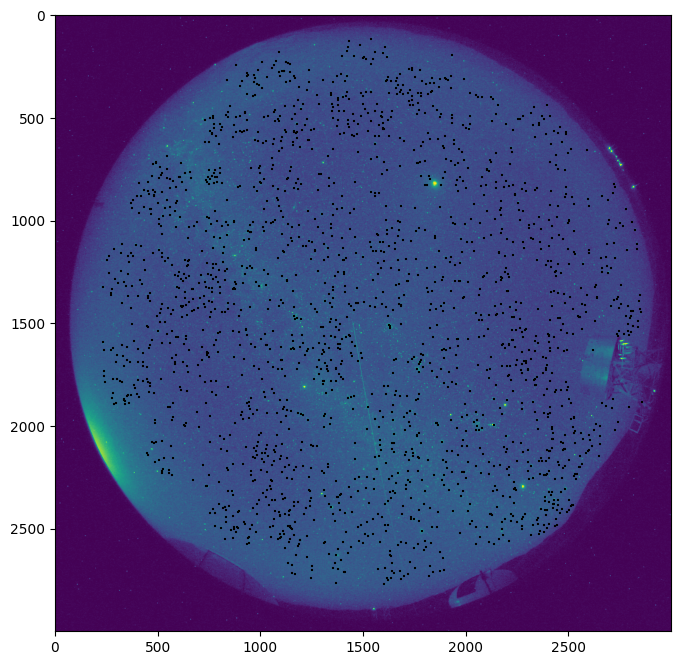

In [6]:
fig,ax = plt.subplots(figsize=(8,8),dpi=100)
ax.imshow(dimg)
plt.scatter(s_tab['field_y'],s_tab['field_x'],c='black',s=1,marker='+')
plt.show()